In [13]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS

from scipy.stats import linregress, spearmanr
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from preprocess import load_and_preprocess_ENEM_raw_data
from external_data_loading import get_metrics_from_inep_education_summary, get_residencial_earnings_per_capita_gini_index, get_public_safety_metrics, get_siope_data, SIOPE_METRICS_DICT

# 1. Regressores

## 1.1. OLS

In [4]:
def merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_data, enem_data, current_year):
    metrics_added = []
    df2 = enem_data[enem_data["ENEM_year"] == current_year][["UF", "Average score", "Natural Sciences score"]].copy()

    for metric in SIOPE_METRICS_DICT.values():
        try:
            df2 = df2.merge(grouped_siope_data[metric], how = 'left', on = 'UF')
            metrics_added.append(metric)
        except:
            df2 = df2
    
    return df2

In [286]:
def load_and_process_data_for_analysis(year, window):
    print(f"Loading data for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    enem_df.drop(columns = "UF", inplace = True)
    enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)

    # get metrics average values over last 'window' years
    print(f"Processing SIOPE data")
    grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df["year"] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()
    siope_metrics_to_discard = (grouped_siope_df.isna().sum() > 0).where(lambda x: x == True).dropna().index
    grouped_siope_df.drop(columns = siope_metrics_to_discard, inplace = True)
    grouped_siope_df = (grouped_siope_df - grouped_siope_df.min())/(grouped_siope_df.max() - grouped_siope_df.min())

    # Discard metrics to which there are null values (generally, UF's that are not in SIOPE's database for these years)
    siope_metrics_to_discard = (grouped_siope_df.isna().sum() > 0).where(lambda x: x == True).dropna().index
    grouped_siope_df.drop(columns = siope_metrics_to_discard, inplace = True)

    print(f"Merging ENEM and SIOPE data")
    enem_with_siope_df = enem_df.merge(grouped_siope_df, on = "UF", how = "inner")

    print("Ready to start analysis!")

    return enem_with_siope_df

In [332]:
def get_dummies_for_categorical_variables(df):
    print("Generating dummy variables...")
    df_dummies = pd.get_dummies(enem_with_siope_df.drop(columns = ["TP_ESCOLA", "Natural Sciences score", "Humanities score", "Languages score",
                                                        "ENEM_year", "Math score"]),
                        columns = ['Age group', 'Gender', 'Marital state', 'Ethinicity', 'Nacionality',
                                    'Q001', 'Q002', 'Q003', 'Q004',
                                    'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013',
                                    'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
                                    'Q023', 'Q024', 'Q025', 'School type'])
    return df_dummies

In [ ]:
def select_features_through_pca(X_train, n_components, top_features):
    print(f"Fitting PCA to training data...")
    pca = PCA(n_components = n_components)
    pca.fit(X_train)
    features_to_use = []

    explained_variance = pca.explained_variance_ratio_

    components_to_features_df = pd.DataFrame(pca.components_,columns=X_train.columns, index = ["PC" + f"{i}" for i in range(1, n_components + 1)])

    print("Evaluating features...")
    # for component in components_to_features_df.index:
    for component in ["PC1"]:
        aux_list = abs(components_to_features_df.loc[component, :]).sort_values(ascending = False)[0:top_features].index.to_list()
        
        for feature in aux_list:
            features_to_use.append(feature)

    print("Found the set of features!")
    return list(set(features_to_use)), explained_variance, components_to_features_df 

In [3]:
# Reading SIOPE data
siope_df = siope_df = get_siope_data("../Datasets/external-data/siope-data")

In [346]:
years_to_analyze = np.arange(2015, 2023)
window = 8

for year in [2022]:
    year_results = {}
    print("---------------------------------------------")
    df = load_and_process_data_for_analysis(year, window)
    df = get_dummies_for_categorical_variables(df)

    print(f"Splitting data into training and test sets")
    X_train, X_test, y_train, y_test = train_test_split(df.dropna().drop(columns = ["Average score", "UF"]),
                                                    df.dropna()["Average score"],
                                                    test_size = 0.3,
                                                    random_state = 1)
    
    features, variance, components_df = select_features_through_pca(X_train, n_components = 5, top_features = 15)

    print("Training linear regressor...")
    linear_regressor = OLS(endog = y_train,
                       exog = X_train[features],
                       hasconst = False).fit()   
    
    print("Training linear mixed model...")
    LMM = sm.MixedLM(endog = y_train,
                   exog = X_train[features],
                   groups = df.loc[X_train.index, :]["UF"]).fit()
    
    print("Storing results...")
    year_results["features"] = features
    year_results["pca_variances"] = variance
    year_results["pca_weights"] = components_df
    year_results["pca"] = pca
    year_results["LR"] = linear_regressor
    year_results["LMM"] = LMM
    year_results["y_train"] = y_train
    year_results["y_test"] = y_test
    year_results["X_train"] = X_train
    year_results["X_test"] = X_test
    joblib.dump(f"modelling_analysis_{year}.pkl")

    del linear_regressor, LMM, features, variance, components_df, df, X_train, X_test, y_train, y_test


---------------------------------------------
Loading data for ENEM 2022
Processing SIOPE data
Merging ENEM and SIOPE data
Ready to start analysis!
Generating dummy variables...
Splitting data into training and test sets
Fitting PCA to training data...
Evaluating features...
Found the set of features!
Training linear regressor...
Training linear mixed model...
Storing results...


FileNotFoundError: [Errno 2] No such file or directory: 'modelling_analysis_2022.pkl'

In [347]:
linear_regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Average score   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                          2.419e+06
Date:                Sun, 17 Sep 2023   Prob (F-statistic):                        0.00
Time:                        00:01:58   Log-Likelihood:                     -7.9495e+06
No. Observations:             1328345   AIC:                                  1.590e+07
Df Residuals:                 1328329   BIC:                                  1.590e+07
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Q013_A                        182.9576      0.372    491.362      0.000     182.228     183.687
Age group_3                    64.3497      0.248    259.709      0.000      63.864      64.835
School type_No answer         106.3833      0.312    340.466      0.000     105.771     106.996
Q013_B                        202.8653      0.356    570.284      0.000     202.168     203.562
Marital state_1               225.1207      0.335    672.279      0.000     224.464     225.777
Age group_2                    73.7028      0.246    299.089      0.000      73.220      74.186
Q001_B                        -11.9477      0.258    -46.333      0.000     -12.453     -11.442
Q010_A                        -15.5207      0.199    -78.079      0.000     -15.910     -15.131
Q002_B                        -10.5830      0.306    -34.623      0.000     -11.182      -9.984
Age group_11                    6.1479      0.476     12.912      0.000       5.215       7.081
Q008_B                        -17.5130      0.202    -86.853      0.000     -17.908     -17.118
School type_Public             52.6431      0.312    168.714      0.000      52.032      53.255
Age group_12                    2.4844      0.654      3.799      0.000       1.203       3.766
Q022_E                         40.4704      0.204    198.467      0.000      40.071      40.870
Marital state_2               180.4713      0.586    308.000      0.000     179.323     181.620
High school conclusion year     6.6086      0.031    212.183      0.000       6.548       6.670
==============================================================================
Omnibus:                   197026.837   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           357526.483
Skew:                           0.958   Prob(JB):                         0.00
Kurtosis:                       4.670   Cond. No.                         32.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [333]:
linear_regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Average score   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          2.017e+06
Date:                Sat, 16 Sep 2023   Prob (F-statistic):                        0.00
Time:                        23:50:13   Log-Likelihood:                     -7.3272e+06
No. Observations:             1328345   AIC:                                  1.465e+07
Df Residuals:                 1328295   BIC:                                  1.466e+07
Df Model:                          50                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Q021_B                          2.673e+11   2.52e+11      1.063      0.288   -2.26e+11     7.6e+11
School type_No answer            -10.5875      0.227    -46.627      0.000     -11.033     -10.142
Q003_C                            -1.5021      0.132    -11.422      0.000      -1.760      -1.244
Q024_A                           -41.8292      0.213   -195.970      0.000     -42.248     -41.411
Q013_B                            -0.4757      0.283     -1.679      0.093      -1.031       0.080
Q018_A                         -3.453e+10   9.93e+10     -0.348      0.728   -2.29e+11     1.6e+11
Q014_B                            14.8076      0.473     31.331      0.000      13.881      15.734
Age group_11                      -0.0467      0.299     -0.156      0.876      -0.632       0.539
Marital state_2                  -10.4836      0.393    -26.704      0.000     -11.253      -9.714
Age group_1                      -16.3725      0.204    -80.310      0.000     -16.772     -15.973
Gender_F                       -2.328e+11   2.31e+11     -1.007      0.314   -6.86e+11     2.2e+11
Q021_A                          2.673e+11   2.52e+11      1.063      0.288   -2.26e+11     7.6e+11
Q014_A                            16.3280      0.490     33.333      0.000      15.368      17.288
Q008_C                            -7.9960      0.199    -40.282      0.000      -8.385      -7.607
Q010_B                            -3.1284      0.196    -15.990      0.000      -3.512      -2.745
Q018_B                         -3.453e+10   9.93e+10     -0.348      0.728   -2.29e+11     1.6e+11
Q006_B                           -10.9918      0.139    -79.183      0.000     -11.264     -10.720
Ethinicity_1                      15.8300      0.163     97.209      0.000      15.511      16.149
Q010_A                            -7.6332      0.229    -33.404      0.000      -8.081      -7.185
Q002_B                           -10.1751      0.199    -51.069      0.000     -10.566      -9.785
Q019_B                            -1.0716      0.127     -8.421      0.000      -1.321      -0.822
School type_Public               -23.7101      0.215   -110.312      0.000     -24.131     -23.289
Q011_B                             8.4339      0.326     25.834      0.000       7.794       9.074
Age group_12                      -6.1513      0.410    -15.003      0.000      -6.955      -5.348
Q022_E                             0.2272      0.161      1.414      0.157      -0.088       0.542
Ethinicity_3                       2.2497      0.157     14.362      0.000       1.943       2.557
EI_to_total_education_expanses    -3.8452      0.266    -14.450      0.000      -4.367      -3.324
Q009_C        

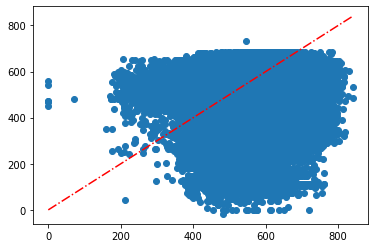

In [348]:
plt.scatter(y_train, linear_regressor.predict(X_train[features]))
xx = np.linspace(y_train.min(), y_train.max())
yy = xx
plt.plot(xx, yy, '-.r')

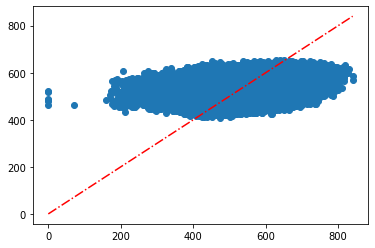

In [335]:
plt.scatter(y_train, linear_regressor.predict(X_train[features]))
xx = np.linspace(y_train.min(), y_train.max())
yy = xx
plt.plot(xx, yy, '-.r')

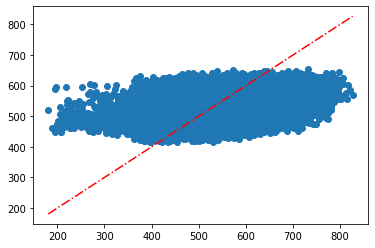

In [340]:
plt.scatter(y_test, linear_regressor.predict(X_test[features]))
xx = np.linspace(y_test.min(), y_test.max())
yy = xx
plt.plot(xx, yy, '-.r')

In [338]:
model = sm.MixedLM(endog = y_train,
                   exog = X_train[features],
                   groups = df.loc[X_train.index, :]["UF"]).fit(reml = False)

c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [343]:
model.summary()

c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2639: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Mixed Linear Model Regression Results
===========================================================================================
Model:                        MixedLM           Dependent Variable:           Average score
No. Observations:             1328345           Method:                       ML           
No. Groups:                   24                Scale:                        3585.0711    
Min. group size:              3257              Log-Likelihood:               -7320854.8472
Max. group size:              254391            Converged:                    Yes          
Mean group size:              55347.7                                                      
-------------------------------------------------------------------------------------------
                                Coef.     Std.Err.     z     P>|z|    [0.025       0.975]  
-------------------------------------------------------------------------------------------
Q021_B                         -343.074                                                    
School type_No answer            -9.900       0.222  -44.639 0.000      -10.335      -9.466
Q003_C                           -1.497       0.129  -11.585 0.000       -1.751      -1.244
Q024_A                          -41.003       0.200 -204.546 0.000      -41.396     -40.610
Q013_B                           -0.828       0.281   -2.943 0.003       -1.379      -0.277
Q018_A                          878.758                                                    
Q014_B                           13.218       0.470   28.097 0.000       12.296      14.140
Age group_11                      0.239       0.297    0.804 0.421       -0.344       0.822
Marital state_2                 -10.841       0.391  -27.741 0.000      -11.606     -10.075
Age group_1                     -16.292       0.203  -80.190 0.000      -16.690     -15.894
Gender_F                         -6.689 1564131.937   -0.000 1.000 -3065648.953 3065635.575
Q021_A                         -338.393                                                    
Q014_A                           13.289       0.491   27.078 0.000       12.328      14.251
Q008_C                           -8.179       0.198  -41.348 0.000       -8.567      -7.791
Q010_B                           -3.817       0.195  -19.545 0.000       -4.200      -3.434
Q018_B                          885.652                                                    
Q006_B                          -11.484       0.139  -82.775 0.000      -11.756     -11.212
Ethinicity_1                     15.422       0.164   93.916 0.000       15.101      15.744
Q010_A                           -8.626       0.230  -37.568 0.000       -9.076      -8.176
Q002_B                          -10.555       0.198  -53.201 0.000      -10.944     -10.166
Q019_B                           -0.876       0.127   -6.902 0.000       -1.125      -0.628
School type_Public              -23.257       0.215 -108.218 0.000      -23.678     -22.836
Q011_B                            8.248       0.325   25.373 0.000        7.611       8.885
Age group_12                     -5.795       0.408  -14.199 0.000       -6.594      -4.995
Q022_E                           -0.092       0.160   -0.576 0.565       -0.407       0.222
Ethinicity_3                      2.490       0.157   15.865 0.000        2.183       2.798
EI_to_total_education_expanses    0.811       5.698    0.142 0.887      -10.357      11.979
Q009_C                            1.751       0.155   11.303 0.000        1.448       2.055
Q022_D                            2.057       0.137   15.058 0.000        1.790       2.325
Q013_A                          -12.201       0.295  -41.336 0.000      -12.780     -11.623
Marital state_1                   9.954       0.260   38.260 0.000        9.444      10.464
Q011_A                           13.910       0.315   44.124 0.000       13.292      14.528
Q004_D                

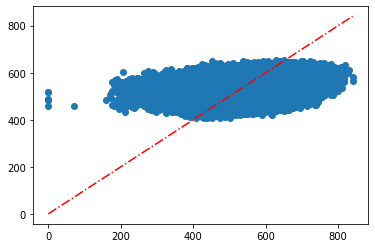

In [339]:
plt.scatter(y_train, model.predict(X_train[features]))
xx = np.linspace(y_train.min(), y_train.max())
yy = xx
plt.plot(xx, yy, '-.r')

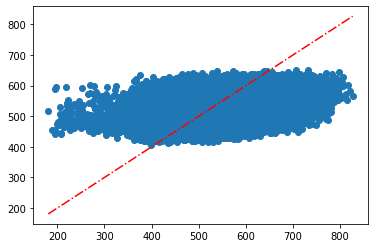

In [341]:
plt.scatter(y_test, model.predict(X_test[features]))
xx = np.linspace(y_test.min(), y_test.max())
yy = xx
plt.plot(xx, yy, '-.r')

In [344]:
r2_score(y_train, model.predict(X_train[features]))

0.29603999388130564

In [300]:
years_to_analyze = np.arange(2015, 2023)
window = 8

for year in [2022]:
    print(f"Running analysis for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    enem_df.drop(columns = "UF", inplace = True)
    enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)

    # get metrics average values over last 'window' years
    print(f"Processing SIOPE data")
    grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df["year"] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()
    siope_metrics_to_discard = (grouped_siope_df.isna().sum() > 0).where(lambda x: x == True).dropna().index
    grouped_siope_df.drop(columns = siope_metrics_to_discard, inplace = True)
    grouped_siope_df = (grouped_siope_df - grouped_siope_df.min())/(grouped_siope_df.max() - grouped_siope_df.min())
    # grouped_siope_df = (grouped_siope_df - grouped_siope_df.mean())/grouped_siope_df.std()

    # Discard metrics to which there are null values (generally, UF's that are not in SIOPE's database for these years)
    siope_metrics_to_discard = (grouped_siope_df.isna().sum() > 0).where(lambda x: x == True).dropna().index
    grouped_siope_df.drop(columns = siope_metrics_to_discard, inplace = True)

    print(f"Merging ENEM and SIOPE data")
    enem_with_siope_df = enem_df.merge(grouped_siope_df, on = "UF", how = "inner")

    
    
print("Done!")


Running analysis for ENEM 2022
Processing SIOPE data
Merging ENEM and SIOPE data
Done!


In [301]:
# Get dummies for categorical data
df = pd.get_dummies(enem_with_siope_df.drop(columns = ["TP_ESCOLA", "Natural Sciences score", "Humanities score", "Languages score",
                                                      "ENEM_year", "Math score"]),
                    columns = ['Age group', 'Gender', 'Marital state', 'Ethinicity', 'Nacionality',
                                   'Q001', 'Q002', 'Q003', 'Q004',
                                   'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013',
                                   'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
                                   'Q023', 'Q024', 'Q025', 'School type'])

In [302]:
# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(df.dropna().drop(columns = ["Average score", "UF"]),
                                                    df.dropna()["Average score"],
                                                    test_size = 0.3,
                                                    random_state = 1)

In [97]:
print(f"Training data shape: {X_train.shape}\nTest data shape: {X_test.shape}")

Training data shape: (1518109, 206)
Test data shape: (379528, 206)


In [289]:
# Apply PCA
pca = PCA(n_components = 5)
pca.fit(X_train)

PCA(n_components=5)

In [326]:
pca.explained_variance_ratio_

array([0.27676503, 0.14896945, 0.08434933, 0.05245317, 0.03978666])

In [167]:
# Acho que aqui foi só com as top features depois do PCA
pca.explained_variance_ratio_

array([0.27685709, 0.14898352, 0.08429308, 0.05243047, 0.03977746])

In [291]:
pca.explained_variance_ratio_.sum()

0.602323628329015

In [169]:
dg = pd.DataFrame(pca.components_,columns=X_train.columns,index = ['PC1','PC2', "PC3", "PC4", "PC5"])

In [ ]:
aux = abs(dg.loc["PC1", :]).sort_values(ascending = False)[0:15]

In [173]:
abs(dg.loc["PC1", :]).sort_values(ascending = False)[0:15]

High school conclusion year           0.985418
FUNDEB_balance                        0.069412
School type_No answer                 0.055888
School type_Public                    0.042891
EB_investment_per_student             0.038410
investment_per_student                0.037634
Age group_2                           0.034138
EM_investment_per_student             0.031056
Age group_3                           0.029324
FUNDEB_teacher_to_total_MDE           0.027562
Marital state_1                       0.026057
Q013_A                                0.024054
education_to_total_MDE_investments    0.023195
superavit_or_deficit                  0.021282
Q010_A                                0.021062
Name: PC1, dtype: float64

In [261]:
# Transforming data following PCA
X_train_pca = pca.transform(X_train.dropna())
X_test_pca = pca.transform(X_test.dropna())

# Transforming data into pandas dataframes
X_train_pca = pd.DataFrame(X_train_pca, columns = ["PC1", "PC2", "PC3", "PC4", "PC5"])
X_test_pca = pd.DataFrame(X_test_pca, columns = ["PC1", "PC2", "PC3", "PC4", "PC5"])

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

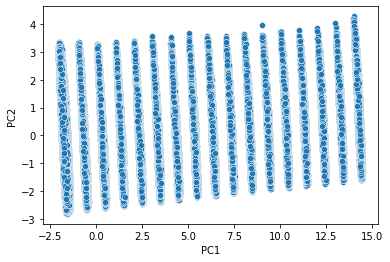

In [262]:
sns.scatterplot(data = X_train_pca,
                x = "PC1",
                y = "PC2")

<AxesSubplot: xlabel='PC1', ylabel='PC3'>

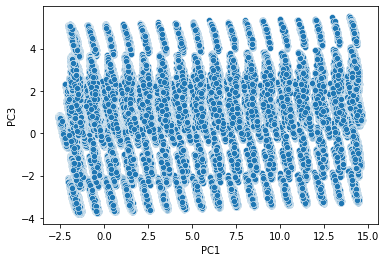

In [177]:
sns.scatterplot(data = X_train_pca,
                x = "PC1",
                y = "PC3")

<AxesSubplot: xlabel='PC2', ylabel='PC3'>

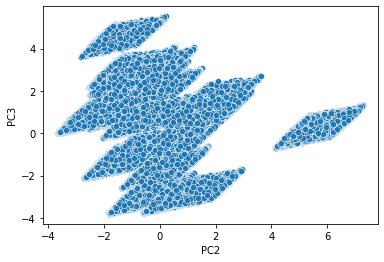

In [178]:
sns.scatterplot(data = X_train_pca,
                x = "PC2",
                y = "PC3")

<AxesSubplot: xlabel='PC3', ylabel='PC4'>

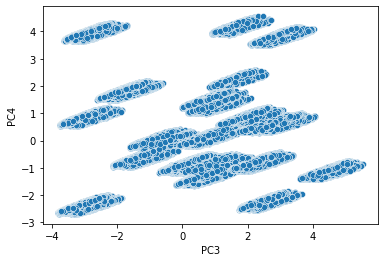

In [179]:
sns.scatterplot(data = X_train_pca,
                x = "PC3",
                y = "PC4")

<AxesSubplot: xlabel='PC4', ylabel='PC5'>

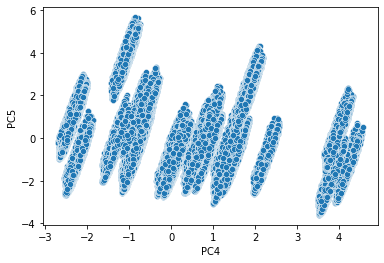

In [180]:
sns.scatterplot(data = X_train_pca,
                x = "PC4",
                y = "PC5")

In [303]:
linear_regressor = OLS(endog = y_train,
                       exog = X_train[features_to_use],
                       hasconst = False).fit()

In [304]:
linear_regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Average score   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                          2.435e+06
Date:                Sat, 16 Sep 2023   Prob (F-statistic):                        0.00
Time:                        21:22:53   Log-Likelihood:                     -7.9866e+06
No. Observations:             1328345   AIC:                                  1.597e+07
Df Residuals:                 1328330   BIC:                                  1.597e+07
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
High school conclusion year            8.7307      0.028    314.634      0.000       8.676       8.785
FUNDEB_balance                        -2.7522      0.543     -5.068      0.000      -3.817      -1.688
School type_No answer                112.8322      0.316    356.704      0.000     112.212     113.452
School type_Public                    54.9368      0.314    174.699      0.000      54.320      55.553
EB_investment_per_student            120.2595      2.237     53.762      0.000     115.875     124.644
investment_per_student               -46.9083      1.861    -25.202      0.000     -50.556     -43.260
Age group_2                           74.4612      0.254    292.627      0.000      73.963      74.960
EM_investment_per_student             86.0450      0.678    126.969      0.000      84.717      87.373
Age group_3                           65.8303      0.255    258.109      0.000      65.330      66.330
FUNDEB_teacher_to_total_MDE          191.6082      0.526    364.186      0.000     190.577     192.639
Marital state_1                      171.8683      0.298    575.931      0.000     171.283     172.453
Q013_A                                -7.2884      0.185    -39.398      0.000      -7.651      -6.926
education_to_total_MDE_investments   116.5848      0.413    282.617      0.000     115.776     117.393
superavit_or_deficit                 122.1841      0.530    230.682      0.000     121.146     123.222
Q010_A                               -14.1188      0.188    -74.973      0.000     -14.488     -13.750
==============================================================================
Omnibus:                    15813.126   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16718.138
Skew:                           0.253   Prob(JB):                         0.00
Kurtosis:                       3.217   Cond. No.                         140.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

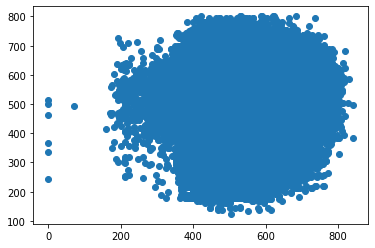

In [305]:
plt.scatter(y_train, linear_regressor.predict(X_train[features_to_use]))

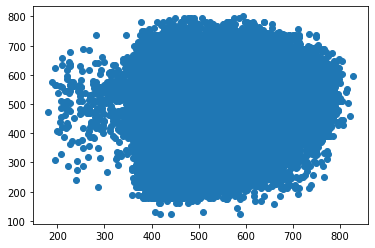

In [306]:
plt.scatter(y_test, linear_regressor.predict(X_test[features_to_use]))

In [ ]:
# Using top features


In [194]:
features_to_use = abs(dg.loc["PC1", :]).sort_values(ascending = False)[0:15].index.to_list()

In [196]:
# Apply PCA
pca = PCA(n_components = 5)
pca.fit(X_train[features_to_use])

PCA(n_components=5)

In [197]:
pca.explained_variance_ratio_

array([0.55329381, 0.26011041, 0.06106204, 0.03032653, 0.01734207])

In [198]:
pca.explained_variance_ratio_.sum()

0.9221348636587002

In [205]:
X_train_pca = pd.DataFrame(pca.transform(X_train[features_to_use]), columns = ["PC" + f"{i}" for i in range(1,6)])

<AxesSubplot: xlabel='PC4', ylabel='PC5'>

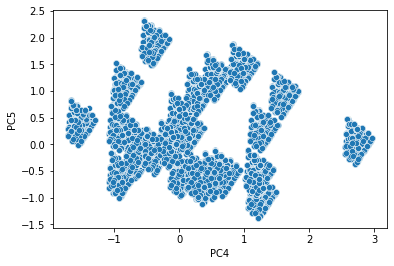

In [207]:
sns.scatterplot(data = X_train_pca,
                x = "PC4",
                y = "PC5")

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

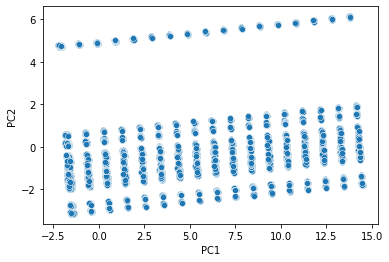

In [208]:
sns.scatterplot(data = X_train_pca,
                x = "PC1",
                y = "PC2")

In [209]:
linear_regressor = OLS(endog = y_train.reset_index(drop=True),
                       exog = X_train_pca,
                       hasconst = False).fit()

In [210]:
linear_regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Average score   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              271.9
Date:                Sat, 16 Sep 2023   Prob (F-statistic):                   1.01e-291
Time:                        20:28:23   Log-Likelihood:                     -1.1670e+07
No. Observations:             1518109   AIC:                                  2.334e+07
Df Residuals:                 1518104   BIC:                                  2.334e+07
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PC1            1.1401      0.118      9.688      0.000       0.909       1.371
PC2            5.0079      0.172     29.177      0.000       4.671       5.344
PC3            1.2867      0.354      3.632      0.000       0.592       1.981
PC4            1.4196      0.503      2.824      0.005       0.434       2.405
PC5          -13.1836      0.665    -19.833      0.000     -14.486     -11.881
==============================================================================
Omnibus:                    48039.892   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52733.306
Skew:                           0.455   Prob(JB):                         0.00
Kurtosis:                       3.078   Cond. No.                         5.65
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

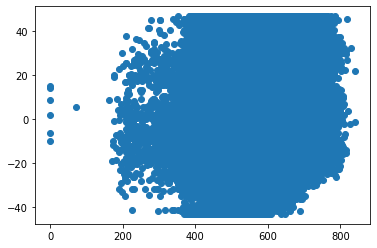

In [212]:
plt.scatter(y_train, linear_regressor.predict(X_train_pca))

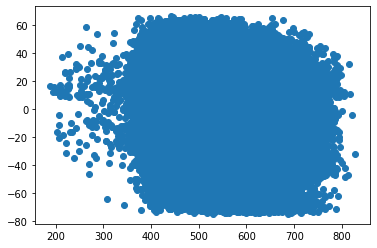

In [216]:
plt.scatter(y_test, linear_regressor.predict(X_test_pca))

In [223]:
df.loc[X_train.index, :]["UF"]

1881809    AP
1139517    MA
656368     SP
1391094    PI
363780     RJ
           ..
491263     PE
1840200    PB
470924     PE
491755     PE
128037     BA
Name: UF, Length: 1518109, dtype: object

In [307]:
model = sm.MixedLM(endog = y_train,
                   exog = X_train[features_to_use],
                   groups = df.loc[X_train.index, :]["UF"]).fit(reml = False)

In [308]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
=======================================================================================
Model:                      MixedLM          Dependent Variable:          Average score
No. Observations:           1328345          Method:                      ML           
No. Groups:                 24               Scale:                       4148.1027    
Min. group size:            3257             Log-Likelihood:              -7417804.0165
Max. group size:            254391           Converged:                   Yes          
Mean group size:            55347.7                                                    
---------------------------------------------------------------------------------------
                                     Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
---------------------------------------------------------------------------------------
High school conclusion year            2.531    0.019  135.429 0.000     2.494    2.567
FUNDEB_balance                        14.049  148.837    0.094 0.925  -277.666  305.764
School type_No answer                -27.068    0.232 -116.787 0.000   -27.522  -26.613
School type_Public                   -48.020    0.219 -218.815 0.000   -48.451  -47.590
EB_investment_per_student            508.162  451.471    1.126 0.260  -376.704 1393.028
investment_per_student              -339.215  383.343   -0.885 0.376 -1090.552  412.123
Age group_2                            3.335    0.174   19.140 0.000     2.994    3.677
EM_investment_per_student            166.843  115.226    1.448 0.148   -58.996  392.682
Age group_3                            4.108    0.173   23.815 0.000     3.770    4.447
FUNDEB_teacher_to_total_MDE          291.303   85.055    3.425 0.001   124.599  458.007
Marital state_1                       17.568    0.226   77.658 0.000    17.125   18.012
Q013_A                               -22.914    0.124 -185.411 0.000   -23.156  -22.672
education_to_total_MDE_investments   248.615   70.028    3.550 0.000   111.363  385.868
superavit_or_deficit                 395.406  107.305    3.685 0.000   185.091  605.720
Q010_A                               -28.710    0.127 -226.266 0.000   -28.959  -28.461
Group Var                          10601.941   35.189                                  
=======================================================================================

"""

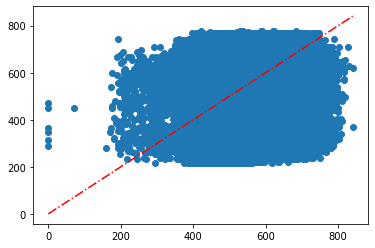

In [309]:
plt.scatter(y_train, model.predict(X_train[features_to_use]))

xx = np.linspace(y_train.min(), y_train.max())
yy = xx 
plt.plot(xx, yy, '-.r')

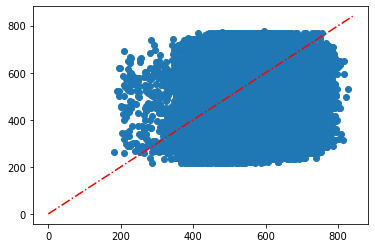

In [310]:
plt.scatter(y_test, model.predict(X_test[features_to_use]))

xx = np.linspace(y_train.min(), y_train.max())
yy = xx 
plt.plot(xx, yy, '-.r')

In [281]:
r2_score(y_test, model.predict(X_test[features_to_use]))

-3.0364597493186745

In [283]:
r2_score(model.predict(X_train[features_to_use]), y_train)

-0.36330559546658314

In [225]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
======================================================================================
Model:                     MixedLM          Dependent Variable:          Average score
No. Observations:          1518109          Method:                      REML         
No. Groups:                24               Scale:                       4147.8313    
Min. group size:           3700             Log-Likelihood:              -8477417.2963
Max. group size:           290797           Converged:                   Yes          
Mean group size:           63254.5                                                    
--------------------------------------------------------------------------------------
                                     Coef.    Std.Err.    z     P>|z|  [0.025   0.975]
--------------------------------------------------------------------------------------
High school conclusion year             2.534    0.017  144.976 0.000    2.500   2.569
FUNDEB_balance                          4.230   93.041    0.045 0.964 -178.127 186.588
School type_No answer                 -27.152    0.217 -125.215 0.000  -27.577 -26.727
School type_Public                    -48.113    0.205 -234.279 0.000  -48.515 -47.710
EB_investment_per_student              -9.210  384.025   -0.024 0.981 -761.884 743.465
investment_per_student                  4.539  363.004    0.013 0.990 -706.936 716.014
Age group_2                             3.285    0.163   20.160 0.000    2.966   3.604
EM_investment_per_student               0.737   94.724    0.008 0.994 -184.919 186.392
Age group_3                             4.049    0.161   25.096 0.000    3.733   4.365
FUNDEB_teacher_to_total_MDE            -3.112   80.654   -0.039 0.969 -161.191 154.966
Marital state_1                        17.602    0.212   83.212 0.000   17.188  18.017
Q013_A                                -22.919    0.116 -198.267 0.000  -23.146 -22.692
education_to_total_MDE_investments     -2.981   75.643   -0.039 0.969 -151.239 145.277
superavit_or_deficit                    0.410   70.361    0.006 0.995 -137.494 138.314
Q010_A                                -28.647    0.119 -241.354 0.000  -28.880 -28.414
Group Var                          106969.386  214.470                                
======================================================================================

"""

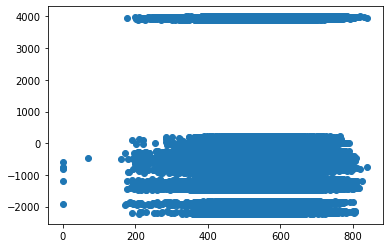

In [241]:
plt.scatter(y_train, model.predict(X_train_pca))

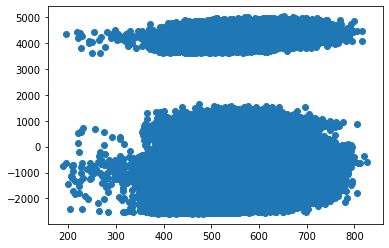

In [242]:
plt.scatter(y_test, model.predict(X_test_pca))

In [245]:
from sklearn.metrics import r2_score
r2_score(y_train, model.predict(X_train_pca))

-809.612396823117

In [247]:
r2_score(y_test, model.predict(X_test_pca))

-937.8041815377419

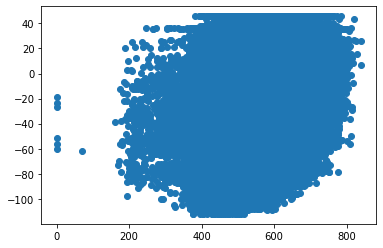

In [233]:
plt.scatter(y_train, model.predict(X_train[features_to_use]))

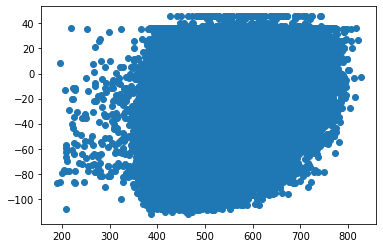

In [234]:
plt.scatter(y_test, model.predict(X_test[features_to_use]))